In [1]:
%matplotlib notebook
import numpy as np
import aipy
import matplotlib.pyplot as plt
from hera_sim import sigchain
import uvtools

In [17]:
fqs = np.linspace(.1,.2,1024,endpoint=False)
bandpass = sigchain.gen_gains(fqs, [0])[0]
#bandpass = np.ones(1024)

# For two major sources interfering, the signal
# will be an interference pattern - sin**2 function.
sig = np.exp(1j*2*np.pi*np.linspace(1,4,1024))

<IPython.core.display.Javascript object>


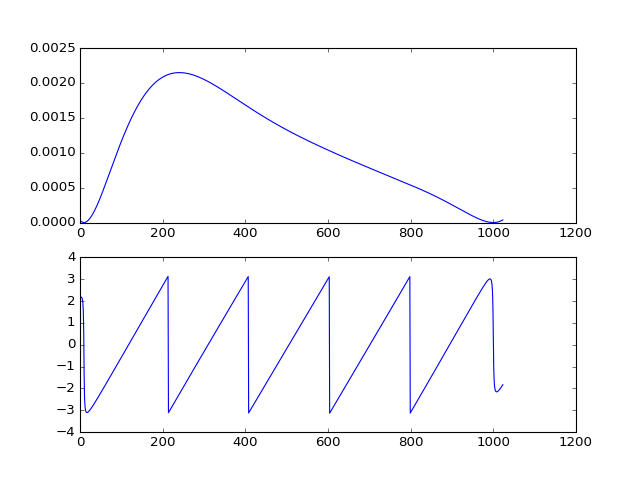

In [18]:
sig_meas = (bandpass**2)*sig

plt.figure()
#plt.plot(np.abs(bandpass))
plt.subplot(211)
plt.plot(np.abs(sig_meas))
plt.subplot(212)
plt.plot(np.angle(sig_meas))

<IPython.core.display.Javascript object>


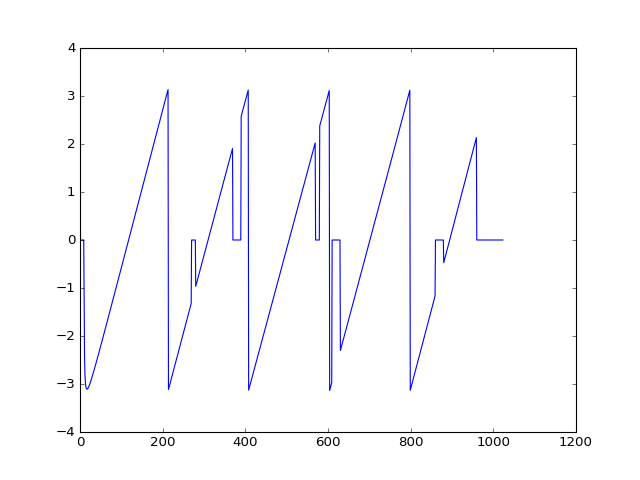

In [19]:
# Say you remove a part of the bandpass (due to RFI etc)
kernel = np.concatenate([np.zeros(10),np.ones(260),np.zeros(10),np.ones(90),\
                         np.zeros(20),np.ones(180),np.zeros(10),np.ones(30),\
                         np.zeros(20),np.ones(230),np.zeros(20),np.ones(80),\
                         np.zeros(1024-960)])

sig_cut = [sig_meas[i] if (kernel[i] == 1) else 0 for i in range(1024)]

plt.figure()
#plt.plot(np.abs(sig_meas))
plt.plot(np.angle(sig_cut))

<IPython.core.display.Javascript object>


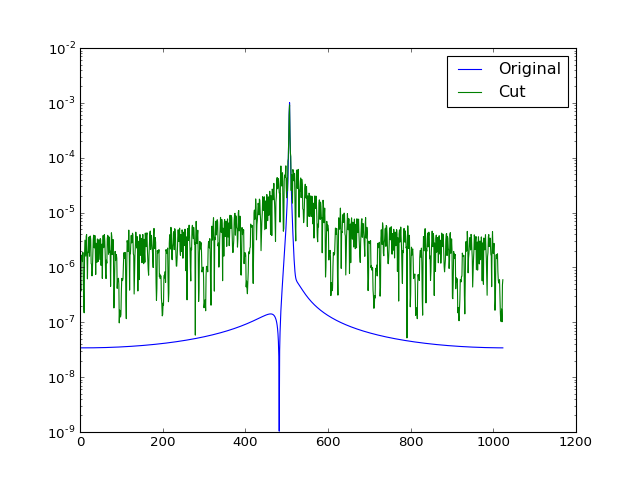

In [26]:
dspec_meas = np.fft.ifft(sig_meas)
dspec_cut = np.fft.ifft(sig_cut)

plt.figure()
plt.semilogy(np.abs(np.fft.fftshift(dspec_meas)),label='Original')
plt.semilogy(np.abs(np.fft.fftshift(dspec_cut)),label='Cut')
plt.legend()

In [27]:
#kernel = np.logical_not(np.asarray(kernel,dtype=dspec_cut.dtype))
kernel = np.asarray(kernel,dtype=dspec_cut.dtype)
ker_fft = np.fft.ifft(kernel)

In [34]:
fft_sig_cleaned = aipy.deconv.clean(im=dspec_cut, ker= ker_fft, tol=1e-6)

In [35]:
fft_sig_cleaned[1]

{'iter': 1521, 'res': array([  7.83571811e-08 -3.73947676e-08j,
          8.01034134e-08 -2.71539192e-08j,
          8.63008773e-08 -6.83116532e-10j, ...,
          7.70918129e-08 -3.42019899e-08j,
          7.48381542e-08 -2.99125943e-08j,   7.66845548e-08 -3.57093705e-08j]), 'score': 2.2005973565653545e-08, 'success': True, 'term': 'tol', 'tol': 1e-06}

<IPython.core.display.Javascript object>


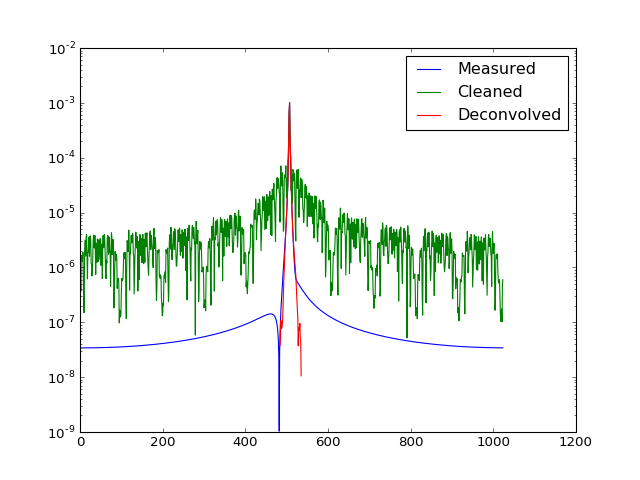

In [63]:
plt.figure()
plt.semilogy(np.abs(np.fft.fftshift(dspec_meas)),label='Measured')
plt.semilogy(np.abs(np.fft.fftshift(dspec_cut)),label='Cleaned')
plt.semilogy(np.abs(np.fft.fftshift(fft_sig_cleaned[0])),label='Deconvolved')
plt.legend()

#plt.plot(np.abs(sig_cut))
#plt.plot(np.fft.fftshift(np.fft.fft(fft_sig_cleaned[0])))

<IPython.core.display.Javascript object>


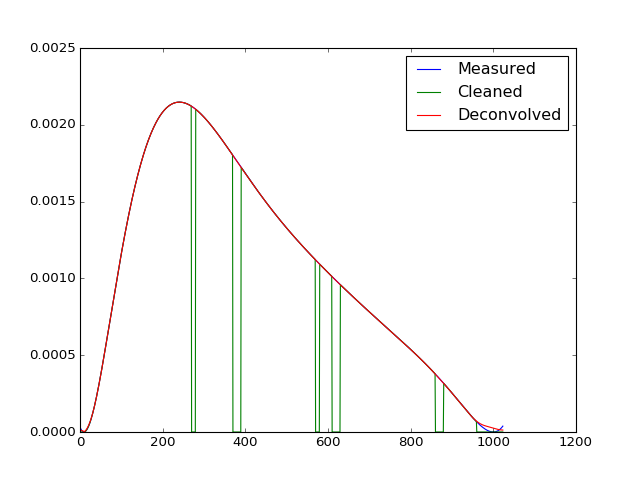

In [37]:
plt.figure()
plt.plot(np.abs(sig_meas),label='Measured')
plt.plot(np.abs(sig_cut),label='Cleaned')
plt.plot(np.abs(np.fft.fft(fft_sig_cleaned[0])),label='Deconvolved')
plt.legend()

In [76]:
import os, glob
files = glob.glob('/home/deepthi/Documents/HERA/Data/calibparams_2458099/zen.*.*.xx.HH.uv.abs.calfits')
files.sort()

In [77]:
len(files)

73

In [78]:
from pyuvdata import UVCal
g = []; flags = []

ant = 23; chan = 512

for fn in files:
    uvc = UVCal()
    uvc.read_calfits(fn)
    flags.append(uvc.flag_array[ant, 0, chan, :, 0])
    g.append(uvc.gain_array[ant, 0, chan, :, 0])
    del(uvc)

flags = np.concatenate(flags)
g = np.concatenate(g)

In [79]:
wgts = np.logical_not(flags)
g = g*wgts

<IPython.core.display.Javascript object>


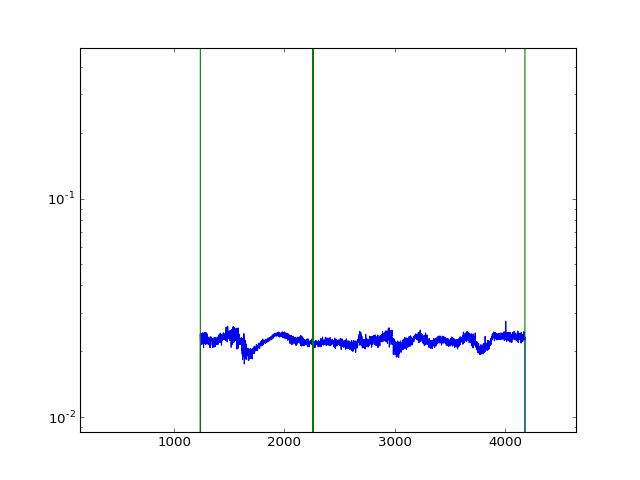

In [80]:
plt.figure()
plt.plot(np.abs(g))
plt.plot(wgts)

In [81]:
# Deconvolve with kernel to supress 
# ringing due to missing data

Fg = np.fft.ifft(g)
Fker = np.fft.ifft(wgts)

Fg_deconv = aipy.deconv.clean(im = Fg, ker = Fker, tol=1e-6)

# plt.figure()
# plt.plot(np.abs(np.fft.fftshift(Fg)),label='Original')
# plt.plot(np.abs(np.fft.fftshift(Fker)),label='FFT of flags')
# plt.plot(np.abs(np.fft.fftshift(Fg_deconv[0])),label='Deconvolved')
# plt.legend()

In [82]:
Fg_deconv[1]

{'iter': 10000, 'res': array([  1.00752474e-05 -9.55535953e-07j,
          9.80220050e-06 +9.37124725e-07j,
         -3.96793975e-06 -9.86690584e-06j, ...,
         -3.87968601e-06 +9.85321392e-06j,
          9.30446960e-06 -4.06084422e-06j,  -2.14660448e-06 +1.00105196e-05j]), 'score': 8.9181749289042798e-06, 'success': False, 'term': 'maxiter', 'tol': 1e-06}

<IPython.core.display.Javascript object>


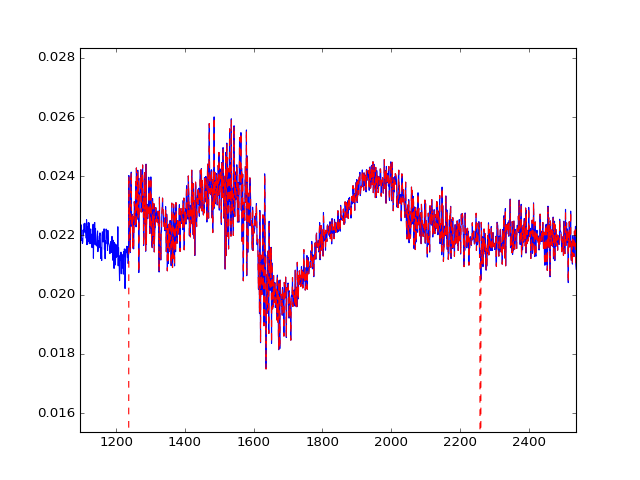

In [84]:
plt.figure()
#plt.plot(np.abs(flags))
#plt.plot(np.abs(np.fft.fft(Fg_deconv[0]+0*(Fg_deconv[1]['res']/Fker[0]))))
plt.plot(np.abs(np.fft.fft(Fg_deconv[0])+np.fft.fft(Fg_deconv[1]['res'])))
plt.plot(np.abs(g),'--r')